## Problem Statement

The number of reported results vary daily. Develop a model to explain this variation and use your model to create a prediction interval for the number of reported results on March 1, 2023. Do any attributes of the word affect the percentage of scores reported that were played in Hard Mode? If so, how? If not, why not?

In [71]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

First, read the dates and the corresponding data.

In [72]:
df = pd.read_excel("./dataset/wordle_data.xlsx", index_col=0, usecols="A,C,D,E,F:L")
df["h/t"] = df["hard_mode_num"] / df["result_num"]
df = df.sort_index()
df

,word,result_num,hard_mode_num,trial_1,trial_2,trial_3,trial_4,trial_5,trial_6,trial_x,h/t
date,,,,,,,,,,,
2022-01-07,slump,80630,1362,1,3,23,39,24,9,1,0.016892
2022-01-08,crank,101503,1763,1,5,23,31,24,14,2,0.017369
2022-01-09,gorge,91477,1913,1,3,13,27,30,22,4,0.020912
2022-01-10,query,107134,2242,1,4,16,30,30,17,2,0.020927
2022-01-11,drink,153880,3017,1,9,35,34,16,5,1,0.019606
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,condo,20879,2012,0,2,17,35,29,14,3,0.096365
2022-12-28,impel,20160,1937,0,3,21,40,25,9,1,0.096081
2022-12-29,havoc,20001,1919,0,2,16,38,30,12,2,0.095945


We would need to normalize the percentage of scores reported that were played in Hard Mode to $[0,1]$.

In [73]:
orimin, orimax = df["h/t"].min(), df["h/t"].max()
df["h/t"] = (df["h/t"] - orimin) / (orimax - orimin)

### Repeatedness of characters (ROC)

We define the ROC of a word by calculating the information entropy of characters in a word, such that

$$ H(X):=-\sum _{x\in\mathcal{X}}p(x)\log p(x)=\mathbb{E}[-\log p(X)]. $$

In [74]:
def charCount(s):
    dic = {}
    for ch in s:
        try:
            dic[ch] += 1
        except KeyError:
            dic[ch] = 1
    return dic

def calc_ROC(s): 
    dic = charCount(s)
    l = [val for val in dic.values()]
    return stats.entropy(l)

ROC increases as the repeatedness of letters in a character drops.

In [75]:
print("ROC of mummy:", calc_ROC("mummy"))
print("ROC of apple:", calc_ROC("apple"))
print("ROC of audio:", calc_ROC("audio"))

ROC of mummy: 0.9502705392332347
ROC of apple: 1.3321790402101223
ROC of audio: 1.6094379124341005


### Percentage of Vowels (POV)

We define the POV of a word by calculating the percentage of vowel characters in a word.

In [76]:
def calc_POV(s):
    I2 = 0
    for c in s:
        if c in ["a", "e", "i", "o", "u"]: I2 += 1
    return I2 / 5

POC increases and the percentage of vowels in a word increases.

In [77]:
print("POV of mummy:", calc_POV("mummy"))
print("POV of apple:", calc_POV("apple"))
print("POV of audio:", calc_POV("audio"))

POV of mummy: 0.2
POV of apple: 0.4
POV of audio: 0.8


### Expectation of yellow hit (EYH) and expectation of green hit (EGH)

*Any formal mathematical definition? @Linyi*

To calculate these attributes, we pulled a wordbank from NYTimes. In our model, a native speaker would randomly pull a word from wordbank and put it in the game. EYH would be the expected number of yellow tiles(different yellow tiles with same character doesn't count), whereas EGH would be the expected number of green tiles, when the wordle game gives him feedback.

In [78]:
totWords = 2309
charRank = {'a': 906, 'b': 266, 'c': 446, 'd': 370, 'e': 1053, 'f': 206, 'g': 299, 'h': 377, 'i': 646, \
            'j': 27, 'k': 202, 'l': 645, 'm': 298, 'n': 548, 'o': 672, 'p': 345, 'q': 29, 'r': 835, \
            's': 617, 't': 667, 'u': 456, 'v': 148, 'w': 193, 'x': 37, 'y': 416, 'z': 35}
charRankByPos = [{'a': 140, 'b': 173, 'c': 198, 'd': 111, 'e': 72, 'f': 135, 'g': 115, 'h': 69, \
                  'i': 34, 'j': 20, 'k': 20, 'l': 87, 'm': 107, 'n': 37, 'o': 41, 'p': 141, 'q': 23, \
                  'r': 105, 's': 365, 't': 149, 'u': 33, 'v': 43, 'w': 82, 'y': 6, 'z': 3}, \
                 {'a': 304, 'b': 16, 'c': 40, 'd': 20, 'e': 241, 'f': 8, 'g': 11, 'h': 144, 'i': 201, 'j': 2, \
                  'k': 10, 'l': 200, 'm': 38, 'n': 87, 'o': 279, 'p': 61, 'q': 5, 'r': 267, 's': 16, 't': 77, \
                  'u': 185, 'v': 15, 'w': 44, 'x': 14, 'y': 22, 'z': 2}, {'a': 306, 'b': 56, 'c': 56, 'd': 75, \
                  'e': 177, 'f': 25, 'g': 67, 'h': 9, 'i': 266, 'j': 3, 'k': 12, 'l': 112, 'm': 61, 'n': 137, 'o': 243, \
                  'p': 57, 'q': 1, 'r': 163, 's': 80, 't': 111, 'u': 165, 'v': 49, 'w': 26, 'x': 12, 'y': 29, 'z': 11}, \
                 {'a': 162, 'b': 24, 'c': 150, 'd': 69, 'e': 318, 'f': 35, 'g': 76, 'h': 28, 'i': 158, 'j': 2, \
                  'k': 55, 'l': 162, 'm': 68, 'n': 182, 'o': 132, 'p': 50, 'r': 150, 's': 171, 't': 139, 'u': 82, \
                  'v': 45, 'w': 25, 'x': 3, 'y': 3, 'z': 20}, {'a': 63, 'b': 11, 'c': 31, 'd': 118, 'e': 422, 'f': 26, \
                  'g': 41, 'h': 137, 'i': 11, 'k': 113, 'l': 155, 'm': 42, 'n': 130, 'o': 58, 'p': 56, 'r': 212, 's': 36, \
                  't': 253, 'u': 1, 'w': 17, 'x': 8, 'y': 364, 'z': 4}]

In [79]:
def calc_rank():
    with open("./dataset/wordle_wordbank.txt") as f:
        lines = f.readlines()
    print(len(lines))
    lines = [s.strip()for s in lines]
    dic = {}
    dic2 = [{} for _ in range(5)]
    for s in lines:
        for c in set(s.lower()):
            try: dic[c] += 1
            except KeyError: dic[c] = 1
        for i, c in enumerate(s):
            try: dic2[i][c] += 1
            except KeyError: dic2[i][c] = 1
    return dict(sorted(dic.items())), [dict(sorted(dic2[i].items())) for i in range(5)]

def calc_EYH(s):
    I3 = 0
    for c in set(s):
        I3 += charRank[c] / totWords
    return I3

# I3G is expectation of green hits
def calc_EGH(s):
    I3 = 0
    for i, c in enumerate(s):
        I3 += charRankByPos[i][c] / totWords
    return I3

*Any further explanation of the EYH and EGH? For instance, how to correlates with the easiness of a guess, etc. @Linyi*

In [80]:
print("mummy: EYH = {}, EGH = {}".format(calc_EYH("mummy"), calc_EGH("mummy")))
print("apple: EYH = {}, EGH = {}".format(calc_EYH("apple"), calc_EGH("apple")))
print("audio: EYH = {}, EGH = {}".format(calc_EYH("audio"), calc_EGH("audio")))

mummy: EYH = 0.5067128627111304, EGH = 0.33997401472498917
apple: EYH = 1.277176266782157, EGH = 0.364660025985275
audio: EYH = 1.3209181463837159, EGH = 0.2667821567778259


### Check the correlation

In [81]:
def get_result(df, func_name, row_name):
    valAttrib = [func_name(word.strip()) for word in df["word"]]
    res = np.asarray(df[row_name])
    pearson = np.corrcoef(valAttrib, res)
    # plt.scatter(valAttrib, res)
    # plt.show()
    return pearson[0][1]

cols = ["trial_" + str(i) for i in range(1, 7)] + ["trial_x"] + ["h/t"]
attribs = [calc_ROC, calc_POV, calc_EYH, calc_EGH]
dic = {}
for attrib in attribs: 
    l = []
    for colname in cols:
        l.append(get_result(df, attrib, colname))
    dic[attrib.__name__[5:]] = l
res = pd.DataFrame(dic, index = cols)
res

,ROC,POV,EYH,EGH
trial_1,0.222949,0.085566,0.338521,0.280004
trial_2,0.362358,0.125828,0.580781,0.335103
trial_3,0.432937,0.006557,0.501621,0.172001
trial_4,0.098531,-0.104577,-0.116221,-0.311545
trial_5,-0.419158,0.034670,-0.521995,-0.259876
trial_6,-0.361306,-0.005921,-0.368545,-0.011690
trial_x,-0.202787,-0.046894,-0.123720,0.099137
h/t,-0.081527,0.079484,-0.039814,-0.119932


*Any possibility of visualizing these data? @Linyi*


Here we visualize the correlation between H/T and word attributes by drawing some subplots.

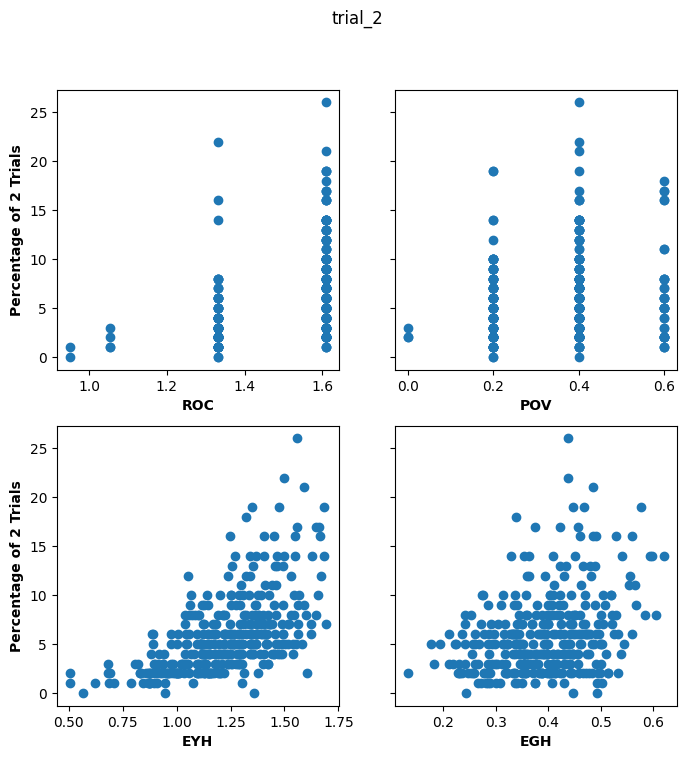

In [82]:
fig, axs = plt.subplots(2, 2, figsize = (8, 8), sharey = True)
axs = axs.reshape((4, ))


def plotAttrib(col):
    def loadPlots(df, func_name, i):
        valAttrib = [func_name(word.strip()) for word in df["word"]]
        res = np.asarray(df[col])
        # low_x, high_x = valAttrib.get_xlim()
        # print(res.max())
        axs[i].scatter(valAttrib, res)
        axs[i].set_xlabel(func_name.__name__[5:], fontweight="bold")
        
    loadPlots(df, calc_ROC, 0), loadPlots(df, calc_POV, 1), loadPlots(df, calc_EYH, 2), loadPlots(df, calc_EGH, 3)
    explain_of_col = 'Percentage of 2 Trials'
    axs[0].set_ylabel(explain_of_col, fontweight="bold")
    axs[2].set_ylabel(explain_of_col, fontweight="bold")

    fig.suptitle(col)
plotAttrib('trial_2')